In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline  

### Variational Autoencoder

* https://arxiv.org/pdf/1312.6114.pdf
* http://norman3.github.io/prml/docs/chapter10/0.html
* http://nolsigan.com/blog/what-is-variational-autoencoder/
* http://jaejunyoo.blogspot.com/2017/04/auto-encoding-variational-bayes-vae-2.html

In [92]:
# Hyper Parameters 
input_size = 784
hidden_size = 128 # undercomplete !
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [51]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='../../dataset/mnist', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='../../dataset/mnist', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [93]:
class Encoder(nn.Module):
    def __init__(self, input_size,hidden_size,drop_p=0.7):
        super(Encoder, self).__init__()
        self.f = nn.Linear(input_size, 256)
        self.f2 = nn.Linear(256, hidden_size)
        self.relu = nn.ReLU()
        self.dropout_h = nn.Dropout(drop_p) 

    def forward(self, x):
        l = self.relu(self.f(x)) # nonlinearity
        l = self.dropout_h(l)
        l2 = self.relu(self.f2(l))
        return l2

class Decoder(nn.Module):
    def __init__(self, input_size,hidden_size,drop_p=0.7,train=True):
        super(Decoder, self).__init__()
        self.f = nn.Linear(hidden_size, 256)
        self.f2 = nn.Linear(256, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout_h = nn.Dropout(drop_p)  
        
    def forward(self, x):
        l = self.relu(self.f(x)) # nonlinearity
        l2 = self.sigmoid(self.f2(l))
        return l2

### ELBO LOSS

In [101]:
encoder = Encoder(input_size,hidden_size)
decoder = Decoder(input_size,hidden_size)
# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
Recon = nn.BCELoss() 
KLD = nn.KLDivLoss()
optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

In [102]:
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28*28))
        normal = Variable(torch.randn([batch_size,hidden_size])) 
        
        # Forward + Backward + Optimize
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
        latent = encoder(images) # q(z|x)
        recon = decoder(latent)
        
        recon_loss = Recon(recon, images)
        kld_loss = KLD(latent,normal)
        
        ELBO = recon_loss-kld_loss
        
        ELBO.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, ELBO.data[0]))

Epoch: [1/5], Step: [100/600], Loss: 0.2528
Epoch: [1/5], Step: [200/600], Loss: 0.2383
Epoch: [1/5], Step: [300/600], Loss: 0.2245
Epoch: [1/5], Step: [400/600], Loss: 0.2246
Epoch: [1/5], Step: [500/600], Loss: 0.2037
Epoch: [1/5], Step: [600/600], Loss: 0.2064
Epoch: [2/5], Step: [100/600], Loss: 0.1945
Epoch: [2/5], Step: [200/600], Loss: 0.2107
Epoch: [2/5], Step: [300/600], Loss: 0.1857
Epoch: [2/5], Step: [400/600], Loss: 0.1817
Epoch: [2/5], Step: [500/600], Loss: 0.2079
Epoch: [2/5], Step: [600/600], Loss: 0.1898
Epoch: [3/5], Step: [100/600], Loss: 0.1842
Epoch: [3/5], Step: [200/600], Loss: 0.1781
Epoch: [3/5], Step: [300/600], Loss: 0.1966
Epoch: [3/5], Step: [400/600], Loss: 0.1832
Epoch: [3/5], Step: [500/600], Loss: 0.1841
Epoch: [3/5], Step: [600/600], Loss: 0.1842
Epoch: [4/5], Step: [100/600], Loss: 0.1768
Epoch: [4/5], Step: [200/600], Loss: 0.1905
Epoch: [4/5], Step: [300/600], Loss: 0.1855
Epoch: [4/5], Step: [400/600], Loss: 0.1782
Epoch: [4/5], Step: [500/600], L

### test 

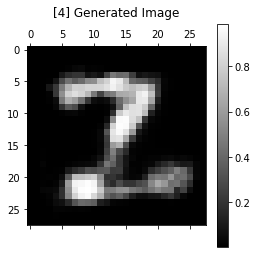

In [112]:
normal = Variable(torch.randn([1,hidden_size])) 
recon = decoder(normal)

plt.matshow(np.reshape(recon.data.numpy(), (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Generated Image\n")
plt.colorbar()
plt.show()